In [2]:
import numpy as np
import matplotlib.pyplot as plt
from TWA_Design_Tools import TWA_Design_Toolkit

In [3]:
# Enter the physical parameters of the antenna 
num_straps = 8
f0 = 96e6
w0 = 2*np.pi*f0
clight = 3e8
Rant = 1.12 # m, hfs of d3d

# See code logbook "my antenna" section. This is for shot 147634. 
n_par = -5 
k_par = w0*n_par/clight
print(f'k_par : {k_par} 1/m')
n_phi = Rant*k_par
print(f'n_phi: {n_phi}')

myTWA = TWA_Design_Toolkit(num_straps=num_straps, f0=f0, k_par_max=k_par)
myTWA.print_key_params()

# set my antenna width to 50% of the distance between straps 
myTWA.set_strap_width(w=10e-2)
print(f'Strap width: {myTWA.wstr*100} cm')




k_par : -10.053096491487338 1/m
n_phi: -11.25946807046582
You are at resonance, so delta_phi = pi/2. Solving for d given k_par:


----------------Parameter--Box-------------------
Distance between strap centers d = 0.15625 m
The first null will be at 5.026548245743669 m^-1
delta_phi = -0.5 pi
Strap length should be less than lambda/4 = 0.7807095260416667 m
--------------END--Parameter--Box----------------


The antenna length is 1.19375 m long
Strap width: 10.0 cm


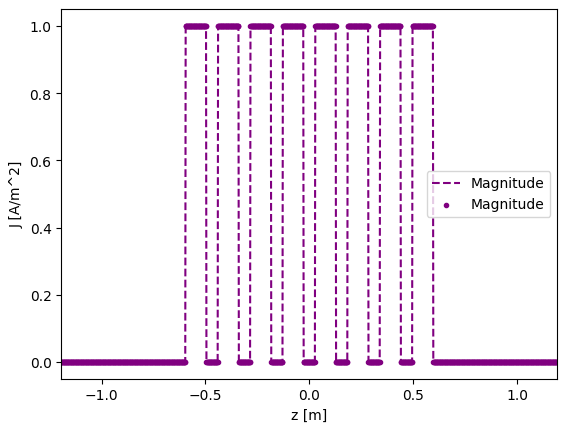

In [4]:
# Confirm that the spectrum is set up correctly 

zrange = 100
num_points = int(1e5) # number of grid points for the z grid
zlim = 2*(num_straps*myTWA.wstr + (num_straps-1)*(myTWA.d - myTWA.wstr))/2
plt.xlim(-zlim, zlim)
myTWA.plot_J_of_z(J0=1, zmin=-zrange, zmax=zrange, num_points=num_points)

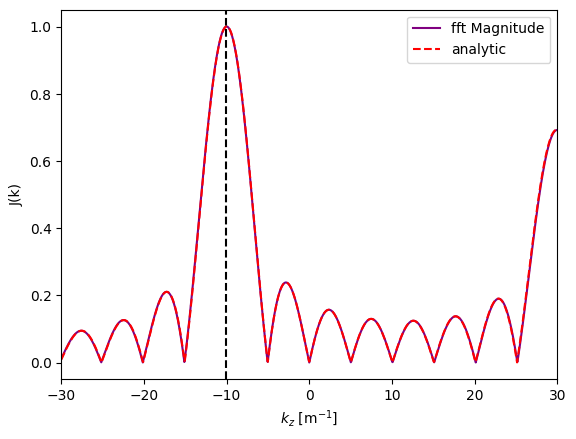

In [5]:
# now, plot the fourier spectrum of power over the k_par number 
myTWA.plot_J_k_versus_k(zmin=-zrange, zmax=zrange, kplotmin=-30, kplotmax=30, num_pointsz=num_points, num_pointsk=1000, J0=1)

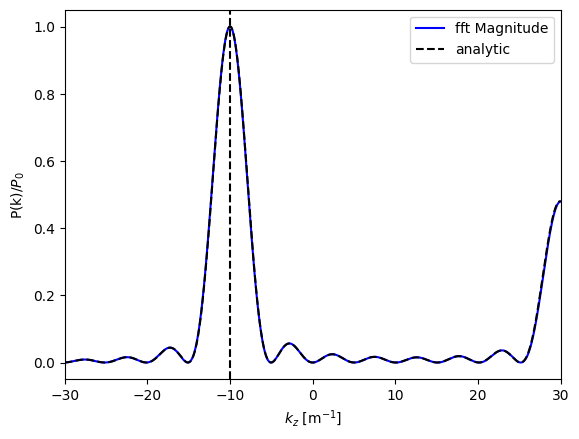

In [6]:
myTWA.plot_normalized_power_versus_k(zmin=-zrange, zmax=zrange, kplotmin=-30, kplotmax=30, num_pointsz=num_points, num_pointsk=1000, J0=1)

In [7]:
print(myTWA.delta_phi)
print(myTWA.w0)
print(myTWA.d)
print(myTWA.k_par_max)

-1.5707963267948966
603185789.4892403
0.15625
-10.053096491487338


[ 4.86136877e-01-0.13634437j  4.30256857e-02+0.71820366j
  4.14395952e-01-0.12486823j  1.01718997e-01-0.14792079j
 -1.22187427e-04-0.0759032j  -1.65102264e-02-0.02720566j
 -1.12636541e-02-0.00659675j -5.45419477e-03-0.00076825j]
The port characteristic impedence is Z0 = 83.12100040448948
C0 =  7.1084691764255785  pF
w: 0.1
h: 0.01
l: 0.08028539842360038
d: 0.15625
Zav:  233.2237714469793
C0check:  7.108469176425578e-12
C0_check2 7.108469176425577e-12


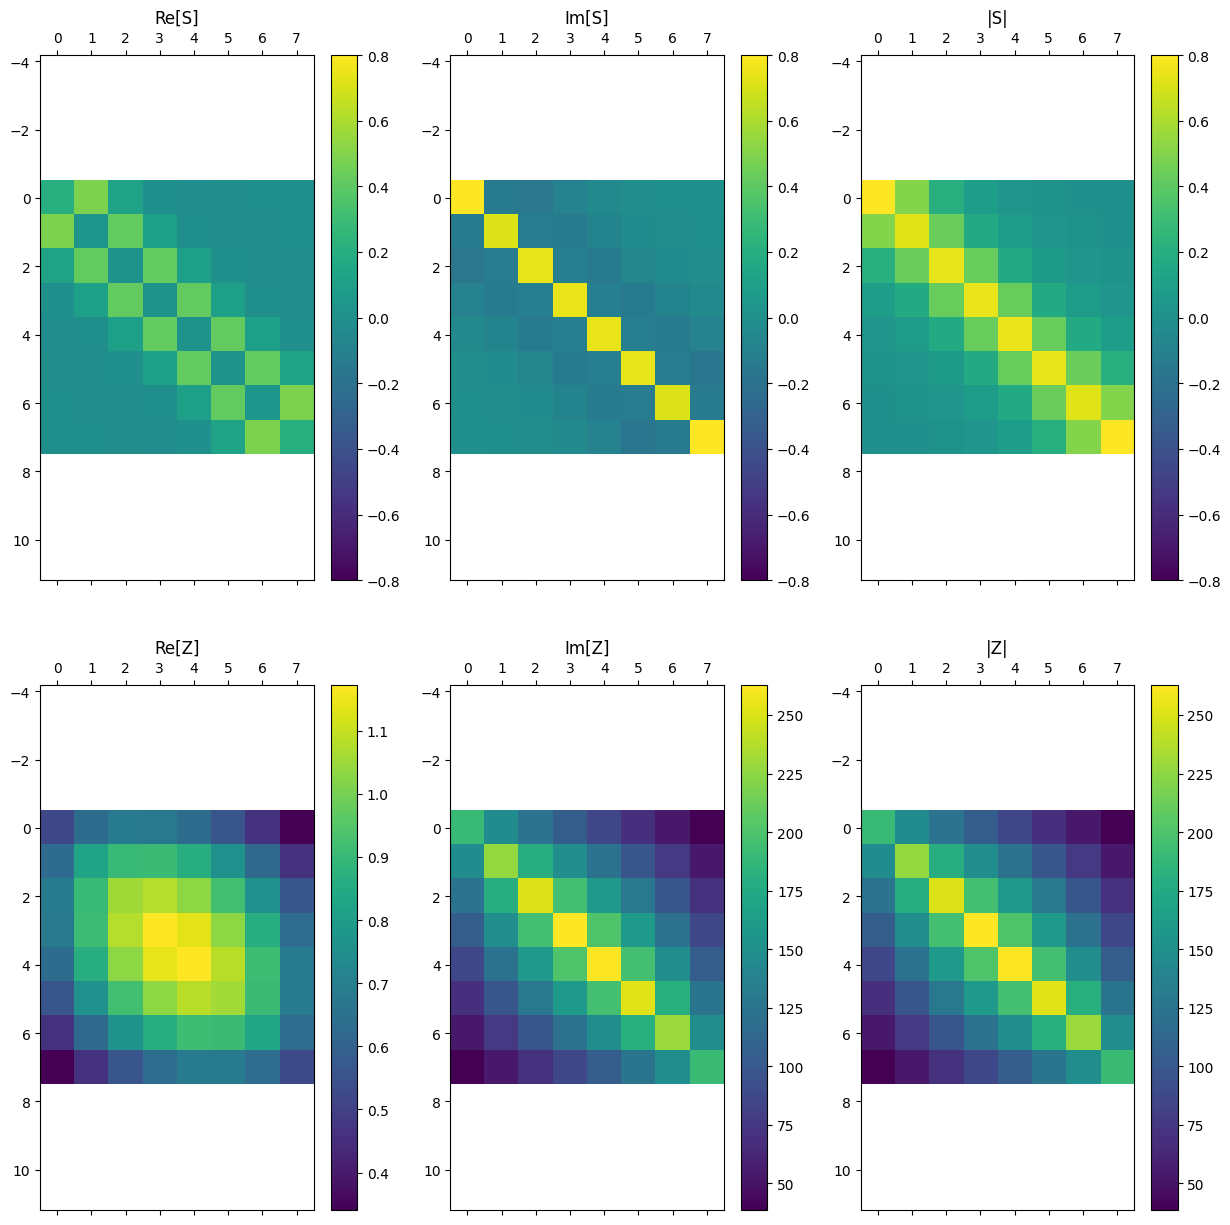

In [12]:
## S and Z matrix Section 

#Smatrix_file_name = 'S_matrix.csv'
#Smatrix_file_name = 'Smat_comsol_96_MHz_on_53_MHz_setup.csv'
# Smatrix_file_name = 'Smat_comsol_53_MHz.csv'
# Smatrix_file_name = 'Smat_comsol_96_MHz_on_shrunk_53_MHz_setup.csv'
Smatrix_file_name = 'Smat_comsol_96_MHz_short_strap.csv'
Smat = myTWA.read_Smat_from_comsol_portscan_Stable(filename=Smatrix_file_name, return_flag=True)
print(Smat[1,:])
Z0 = myTWA.get_coax_Z0(d_outer=0.016, d_inner=0.004)
myTWA.get_Z_matrix(Z0_port=Z0)
print(f'The port characteristic impedence is Z0 = {Z0}')
print('C0 = ', myTWA.calculate_C0()/1e-12, ' pF')


h = .01
#h2 = h/5
w = myTWA.wstr
print(f'w: {w}')
print(f'h: {h}')
A = myTWA.cap_area_given_gap(h)
l = A/w
print(f'l: {l}')
print(f'd: {myTWA.d}')

Zav = np.trace(np.imag(myTWA.Zmatrix))/8
C0check = 1/(Zav*w0)
print('Zav: ', Zav)
print('C0check: ', C0check)
C0_check2  = myTWA.epsi0*myTWA.wstr*l/h
print('C0_check2', C0_check2)
myTWA.plot_Smat_and_Zmat()
# h = .01
# h2 = h/5
# w = myTWA.wstr
# print(f'w: {w}')
# print(f'h2: {h2}')
# A = myTWA.cap_area_given_gap(h2)
# l = A/w
# print(f'l: {l}')
# print(f'd: {myTWA.d}')

# Zav = np.trace(np.imag(myTWA.Zmatrix))/8
# C0check = 1/(Zav*w0)
# print('Zav: ', Zav)
# print('C0check: ', C0check)
# myTWA.plot_Smat_and_Zmat()

 




In [28]:
h = 1e-2
l = .40*53/96
epsi0 = 8.854e-12
w = .10 
ts = 2e-2
Cgap = epsi0*w*ts/h
print('Cgap: ', Cgap/1e-12, 'pF')

Cgap:  1.7708 pF


Text(0.5, 0, 'f [MHz]')

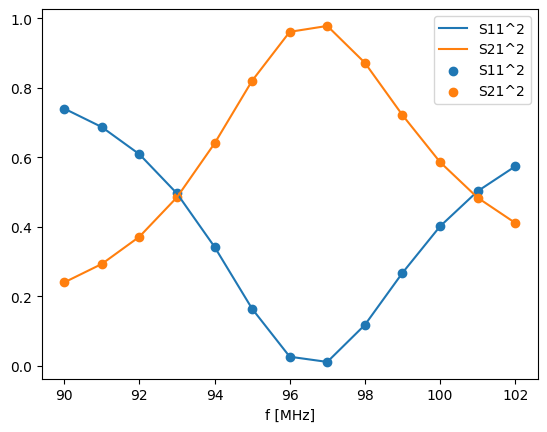

In [24]:
# port scan and outputs the Smatrix 
import csv
filename = 'f_scan_96_MHz.csv'
data = []
with open(filename, 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        data.append(row)

data = data[5:]
fmat_string  = []
for row in data:
    fmat_string.append(row)

fmat = np.array([[complex(num.replace('i', 'j')) for num in row] for row in fmat_string], dtype=complex)
fs = np.real(fmat[:,0])
S11_sqr = np.abs(fmat[:,1])**2
S21_sqr = np.abs(fmat[:,2])**2

plt.plot(fs, S11_sqr, label='S11^2')
plt.plot(fs, S21_sqr, label='S21^2')
plt.scatter(fs, S11_sqr, label='S11^2')
plt.scatter(fs, S21_sqr, label='S21^2')
plt.legend()
plt.xlabel('f [MHz]')

In [8]:
np.savetxt('Smat_testing_R.txt',np.real(Smat))
np.savetxt('Smat_testing_I.txt',np.imag(Smat))

-149.2075101910503

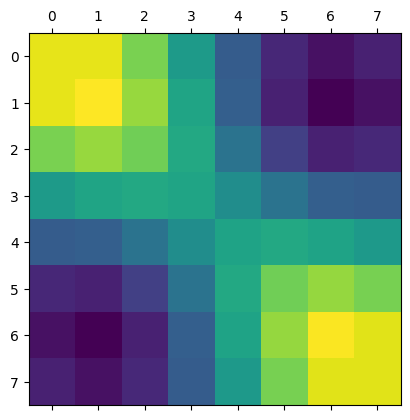

In [9]:
smat_size = Smat.shape[0]  # get the shape of the S matrix
I = np.identity(smat_size, dtype=complex)
Zmatrix = Z0*np.matmul((I + Smat),np.linalg.inv(I - Smat))
plt.matshow(np.real(Zmatrix))
np.trace(np.imag(Zmatrix))/8

In [10]:
import skrf as rf

(1, 8, 8)


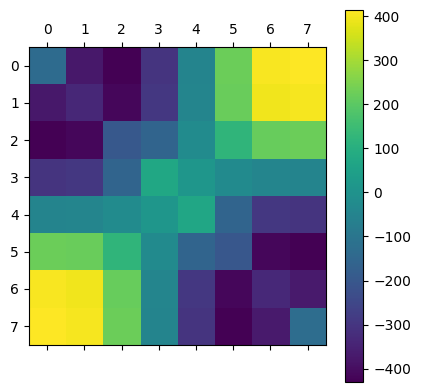

In [11]:
S = np.array([Smat])
print(S.shape)
Zmat = rf.s2z(S, Z0)[0]
plt.matshow(np.imag(Zmat))
plt.colorbar()

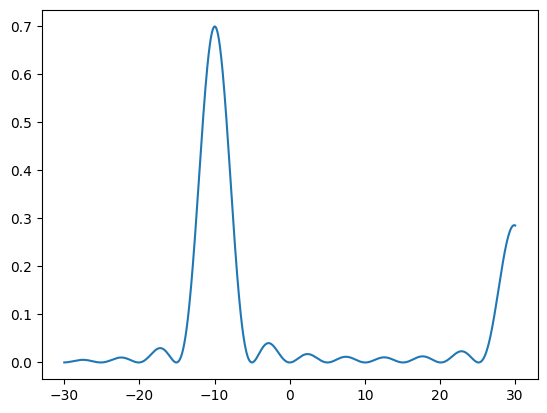

In [12]:
W = 10.9375/100
w0 = f0*2*np.pi
c = 3e8
delta_phi = np.pi/2
d = 0.15625

def get_fft_analytic(k, P0):
    n = k*c/(w0) # TODO why is this negative? 
    if n == 0:
        return 1*P0
    else:
        term1 = np.sin(n*W*w0/(2*c))**2 / n**2
        alpha = delta_phi + n*w0*d/c
        # alpha = self.delta_phi + n*self.w0*self.d/self.clight
        term2 = np.sin(num_straps*alpha/2)**2/np.sin(alpha/2)**2
        return P0*term1 * term2
    
karray = np.linspace(-30, 30, 1000)
anyarray = np.zeros_like(karray)
for i in range(karray.shape[0]):
    anyarray[i] = get_fft_analytic(karray[i], 1)

plt.plot(karray, anyarray)

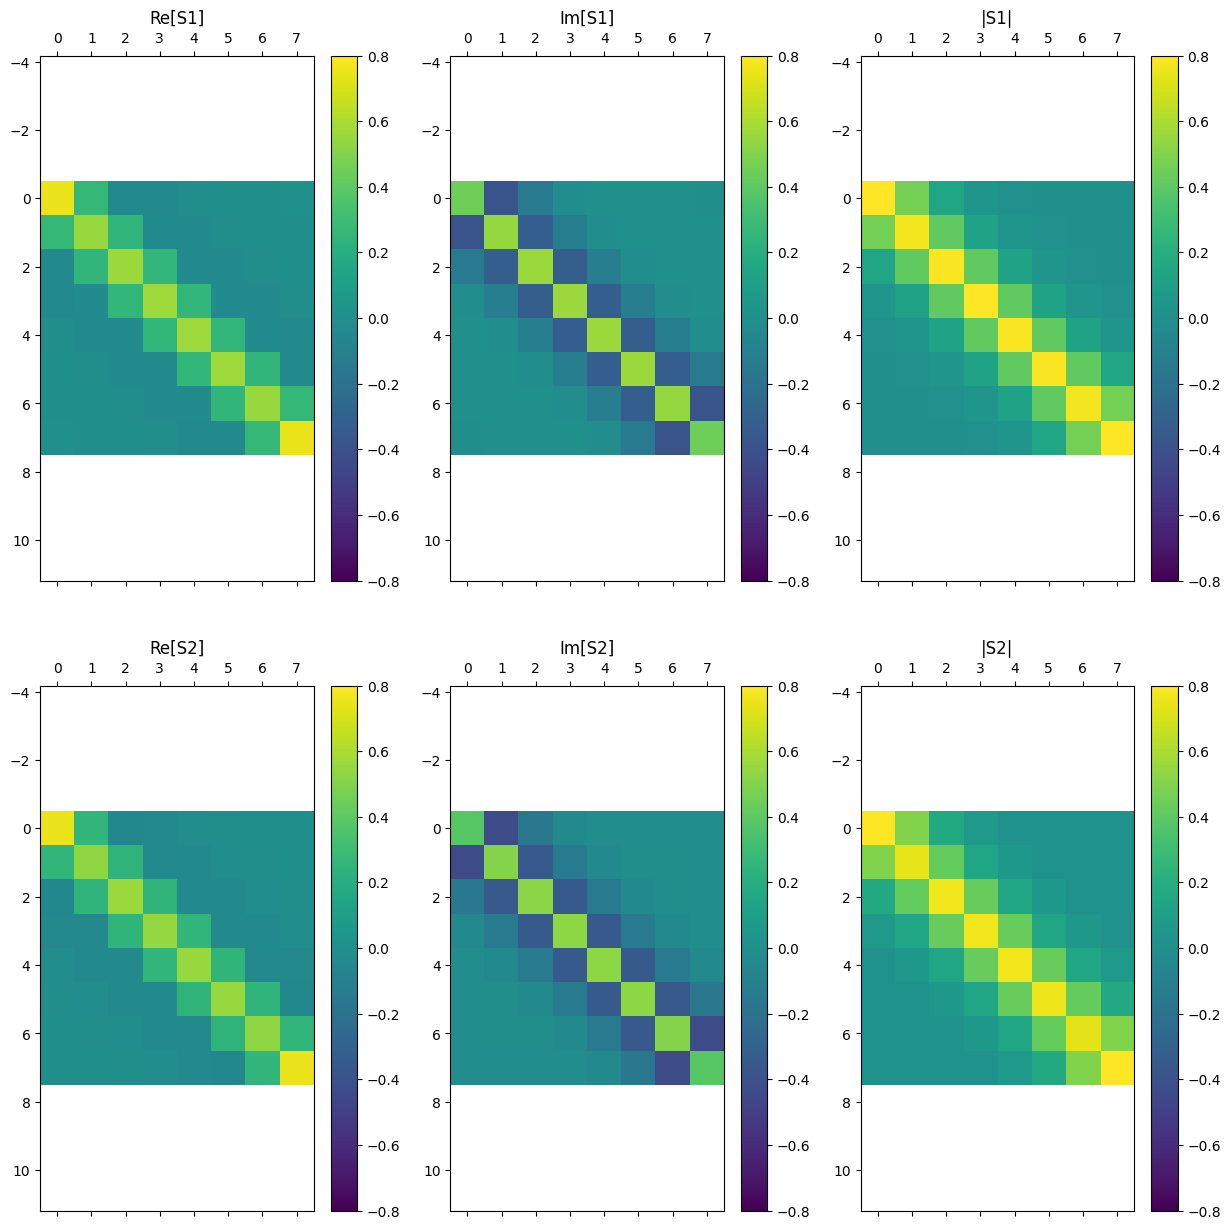

In [13]:
Smatrix_file_name1 = 'S_matrix.csv'
#Smatrix_file_name = 'Smat_comsol_96_MHz.csv'
Smat1 = myTWA.read_Smat_from_comsol_portscan_Stable_depricated(filename=Smatrix_file_name1, return_flag=True)

Smatrix_file_name2 = 'Smat_comsol_96_MHz.csv'
#Smatrix_file_name = 'Smat_comsol_96_MHz.csv'
Smat2 = myTWA.read_Smat_from_comsol_portscan_Stable(filename=Smatrix_file_name2, return_flag=True)


fig, axs = plt.subplots(2, 3, figsize=(15, 15))

s1 = axs[0,0].matshow(np.real(Smat1))
plt.colorbar(s1, ax=axs[0,0])

s2 = axs[0,1].matshow(np.imag(Smat1))
plt.colorbar(s2, ax=axs[0,1])

s3 = axs[0,2].matshow(np.abs(Smat1))
plt.colorbar(s3, ax=axs[0,2])

s1.set_clim(vmin=-.8, vmax=.8)
s2.set_clim(vmin=-.8, vmax=.8)
s3.set_clim(vmin=-.8, vmax=.8)

axs[0,0].axis('equal')
axs[0,1].axis('equal')
axs[0,2].axis('equal')

axs[0,0].set_title('Re[S1]')
axs[0,1].set_title('Im[S1]')
axs[0,2].set_title('|S1|')

s4 = axs[1,0].matshow(np.real(Smat2))
plt.colorbar(s4, ax=axs[1,0])

s5 = axs[1,1].matshow(np.imag(Smat2))
plt.colorbar(s5, ax=axs[1,1])

s6 = axs[1,2].matshow(np.abs(Smat2))
plt.colorbar(s6, ax=axs[1,2])

s4.set_clim(vmin=-.8, vmax=.8)
s5.set_clim(vmin=-.8, vmax=.8)
s6.set_clim(vmin=-.8, vmax=.8)

axs[1,0].axis('equal')
axs[1,1].axis('equal')
axs[1,2].axis('equal')

# s4.set_clim(vmin=-1, vmax=1)
# s5.set_clim(vmin=-1, vmax=1)
# s6.set_clim(vmin=-1, vmax=1)

axs[1,0].set_title('Re[S2]')
axs[1,1].set_title('Im[S2]')
axs[1,2].set_title('|S2|')
plt.show()
# # test loading up smatrix from comsol global matrix solve 
# import csv
# data = []
# filename = 'Smat_comsol_53_MHz.csv'
# with open(filename, 'r') as file:
#     reader = csv.reader(file)
#     for row in reader:
#         data.append(row)

# data = data[5:]
# Smat_string  = []
# for row in data:
#     Smat_string.append(row[1:])

# Smat = np.array([[complex(num.replace('i', 'j')) for num in row] for row in Smat_string], dtype=complex)
# print(complex_array[3,:])



In [14]:
print(Smat2)

[[ 0.75460116+0.38217822j  0.25438992-0.42939364j -0.05578888-0.1609678j
  -0.04464849-0.03956392j -0.01731215-0.01544397j -0.00778592-0.01366876j
  -0.0059803 -0.01449435j -0.0028046 -0.01726478j]
 [ 0.2543896 -0.42939415j  0.53670803+0.50622698j  0.23843944-0.35165427j
  -0.04483539-0.13790127j -0.04161342-0.0328889j  -0.01830094-0.01108571j
  -0.00979447-0.01061746j -0.00596744-0.01447526j]
 [-0.05578915-0.16096794j  0.23843958-0.35165452j  0.55768416+0.52039506j
   0.24788036-0.34852936j -0.0430572 -0.13817374j -0.04140097-0.03197997j
  -0.01838299-0.01107762j -0.00783068-0.01366721j]
 [-0.04464803-0.03956401j -0.04483526-0.13790147j  0.24788018-0.34852936j
   0.54962605+0.53046708j  0.2502675 -0.34759459j -0.04238926-0.13817523j
  -0.04158825-0.03298615j -0.0172814 -0.0154181j ]
 [-0.01731197-0.01544437j -0.04161345-0.03288905j -0.04305744-0.13817382j
   0.25026758-0.34759465j  0.55347279+0.52553314j  0.24868504-0.34894008j
  -0.04518985-0.13847501j -0.04493131-0.03965497j]
 [-0.0